In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from itertools import groupby
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [4]:
import tensorflow

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
tensorflow.__version__

'1.5.1'

In [6]:
%matplotlib inline

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [7]:
from load_data import load_data,class_breakdown

In [8]:
#data_name ="EEG"
data_name ="HAR"

#data_name ="UWaveGestureLibraryAll"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data HAR
batch size:64
train data (7352, 128, 9),(7352, 1)
test data (2947, 128, 9),(2947, 1)


In [9]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=1226, percentage=0.000
Class=2, total=1073, percentage=0.000
Class=3, total=986, percentage=0.000
Class=4, total=1286, percentage=0.000
Class=5, total=1374, percentage=0.000
Class=6, total=1407, percentage=0.000
Class=1, total=496, percentage=0.000
Class=2, total=471, percentage=0.000
Class=3, total=420, percentage=0.000
Class=4, total=491, percentage=0.000
Class=5, total=532, percentage=0.000
Class=6, total=537, percentage=0.000


In [10]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (7352, 6)
y test shape: (2947, 6)


## 데이터 정규화

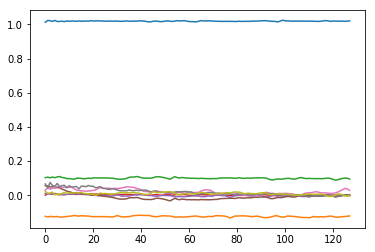

In [11]:
plt.plot(trainx[0])

In [12]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

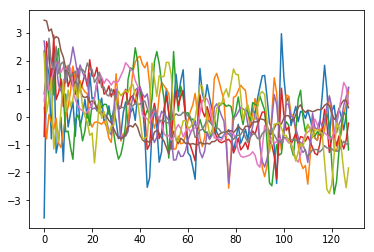

In [13]:
plt.plot(trainx[0])

In [14]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(7352, 1, 128, 9)
trainY shape:(7352, 6)
validX shape:(1473, 1, 128, 9)
validY shape:(1473, 6)
testX shape:(1474, 1, 128, 9)
testY shape:(1474, 6)


In [15]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 128
input_channel 9


# 2. Training condition 정의

In [16]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 300


std= 0.01
l_rate = 1e-5

In [17]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [18]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_last_conv_turnoff

SyntaxError: Non-ASCII character '\xea' in file FCN.py on line 22, but no encoding declared; see http://python.org/dev/peps/pep-0263/ for details (FCN.py, line 22)

In [19]:
import tensorflow as tf

In [20]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

6


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [21]:
import math
if data_name in ["HAR","EEG"]:
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 7
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 4
    pool1_pad = 0
    pool1_stride = 2

    ###### conv2
    conv2_size = 5
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 3
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 2
    pool3_pad = 0
    pool3_stride = 1
elif data_name in "UWaveGestureLibraryAll":
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 15
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 8
    pool1_pad = 0
    pool1_stride = 4

    ###### conv2
    conv2_size = 11
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 7
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 4
    pool3_pad = 0
    pool3_stride = 2

In [22]:
conv1_idx_list=[]
for conv1_idx in range(0,trainX.shape[2],conv1_stride):
    conv1_idx_list.append(np.arange(max(conv1_idx-(conv1_size//2),0), min(conv1_idx+(conv1_size//2) +1 ,trainX.shape[2])))

if conv1_idx < (trainX.shape[2]-1):
    for data_idx in np.arange(conv1_idx+1, trainX.shape[2]):
        conv1_idx_list.append(data_idx)
    
print(len(conv1_idx_list))



pool1_idx_list=[]
for pool1_idx in range(0,len(conv1_idx_list)-(pool1_size-1), pool1_stride):
    temp_idx = []
    for conv1_idx in np.arange(max(pool1_idx,0), min(pool1_idx+pool1_size ,len(conv1_idx_list))):
        temp_idx.extend(conv1_idx_list[conv1_idx])
    if set(temp_idx):
        pool1_idx_list.append(list(set(temp_idx)))
        
if (pool1_idx + pool1_size) < (len(conv1_idx_list)-1):
    temp_idx = []
    for conv1_idx in np.arange(pool1_idx+1, len(conv1_idx_list)):
        temp_idx.extend(conv1_idx_list[conv1_idx])
        pool1_idx_list.append(list(set(temp_idx)))
print(len(pool1_idx_list))


conv2_idx_list=[]
for conv2_idx in range(0,len(pool1_idx_list), conv2_stride):
    temp_idx = []
    for pool1_idx in np.arange(max(conv2_idx-(conv2_size//2),0), min(conv2_idx+(conv2_size//2) +1 ,len(pool1_idx_list))):
        temp_idx.extend(pool1_idx_list[pool1_idx])
    if set(temp_idx):
        conv2_idx_list.append(list(set(temp_idx)))

if conv2_idx < (len(pool1_idx_list)-1):
    print("add")
    temp_idx = []
    for pool1_idx in np.arange(conv2_idx+1, len(pool1_idx_list)):
        conv2_idx_list.append(pool1_idx_list[pool1_idx])
print(len(conv2_idx_list))




pool2_idx_list=[]
for pool2_idx in range(0,len(conv2_idx_list)-(pool2_size-1), pool2_stride):
    temp_idx = []
    for conv2_idx in np.arange(max(pool2_idx ,0), min(pool2_idx+pool2_size ,len(conv2_idx_list))):
        temp_idx.extend(conv2_idx_list[conv2_idx])
    pool2_idx_list.append(list(set(temp_idx)))

if (pool2_idx + pool2_size-1) < (len(conv2_idx_list)-1):
    print('add')
    temp_idx = []
    for conv2_idx in np.arange(pool2_idx+ pool2_size+1, len(conv2_idx_list)):
        pool2_idx_list.append(conv2_idx_list[conv2_idx])
print(len(pool2_idx_list))

conv3_idx_list=[]
for conv3_idx in range(0,len(pool2_idx_list), conv3_stride):
    temp_idx = []
    for pool2_idx in np.arange(max(conv3_idx-(conv3_size//2),0), min(conv3_idx+(conv3_size//2) +1 ,len(pool2_idx_list))):
        temp_idx.extend(pool2_idx_list[pool2_idx])
    if set(temp_idx):
        conv3_idx_list.append(list(set(temp_idx)))

if conv3_idx < (len(pool2_idx_list)-1):
    print("add")
    temp_idx = []
    for pool2_idx in np.arange(conv3_idx+1, len(pool3_idx_list)):
        conv3_idx_list.append(pool2_idx_list[pool2_idx])
print(len(conv3_idx_list))



pool3_idx_list=[]
for pool3_idx in range(0,len(conv3_idx_list)-(pool3_size-1), pool3_stride):
    temp_idx = []
    for conv3_idx in np.arange(max(pool3_idx ,0), min(pool3_idx+pool3_size ,len(conv3_idx_list))):
        temp_idx.extend(conv3_idx_list[conv3_idx])
    pool3_idx_list.append(list(set(temp_idx)))

if (pool3_idx + pool3_size-1) < (len(conv3_idx_list)-1):
    print('add')
    for conv3_idx in np.arange(pool3_idx+ pool3_size+1, len(conv3_idx_list)):
        pool3_idx_list.append(conv3_idx_list[conv3_idx])
print(len(pool3_idx_list))


65
31
31
add
14
14
13


In [23]:
pool1_pattern_len = np.max([len(x) for x in pool1_idx_list])
pool2_pattern_len = np.max([len(x) for x in pool2_idx_list])
pool3_pattern_len = np.max([len(x) for x in pool3_idx_list])

print("pool pattern length : pool1({}),pool2({}),pool3({})".format(pool1_pattern_len,
                                                                     pool2_pattern_len,
                                                                     pool3_pattern_len))

pool pattern length : pool1(13),pool2(41),pool3(65)


In [24]:
pool1_output_len = len(pool1_idx_list)
pool2_output_len = len(pool2_idx_list)
pool3_output_len = len(pool3_idx_list)

# 4. Training

In [25]:
import time
import os
import numpy as np

In [26]:
save_path = './model/'+data_name
model_name = 'LRP_'+data_name+"_CNN_conv3_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

LRP_HAR_CNN_conv3_1e-05_64


In [27]:
from training import get_batch

In [28]:
keep_prob =1.0

In [29]:
true_threshold_weight1 = np.ones(pool1_output_len*conv1_channel).reshape(conv1_channel,pool1_output_len,1,-1)
true_threshold_weight2 = np.ones(pool2_output_len*conv2_channel).reshape(conv2_channel,pool2_output_len,1,-1)
true_threshold_weight3 = np.ones(pool3_output_len*conv3_channel).reshape(conv3_channel,pool3_output_len,1,-1)

train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

In [30]:
pool3_output_len

13

In [31]:
num_epochs= 300

std= 0.01
l_rate = 1e-5

In [32]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 1,trainX.shape[2],trainX.shape[3]])
y_ = tf.placeholder(tf.float32, [None, nb_classes], name="truth")
keep_prob = tf.placeholder(tf.float32,name="keep_probability")

unit_bool = tf.placeholder(tf.float32, [None, 1,len(conv2_idx_list),conv2_channel], name="unit_bool")
#Set the weights for the network
xavier = tf.contrib.layers.xavier_initializer_conv2d()  
conv1_weights = tf.get_variable(name="c1", initializer=xavier, shape=[1, conv1_size, trainX.shape[-1], conv1_channel])
conv1_biases = tf.Variable(tf.zeros([conv1_channel]))
conv2_weights = tf.get_variable(name="c2", initializer=xavier, shape=[1, conv2_size, conv1_channel, conv2_channel])
conv2_biases = tf.Variable(tf.zeros([conv2_channel]))
conv3_weights = tf.get_variable(name="c3", initializer=xavier, shape=[1, conv3_size, conv2_channel, conv3_channel])
conv3_biases = tf.Variable(tf.zeros([conv3_channel]))
fc1_weights = tf.Variable(tf.truncated_normal([1 * pool3_output_len  * conv3_channel, nb_classes], stddev=0.1))
fc1_biases = tf.Variable(tf.zeros([nb_classes]))

#Stack the Layers
reshaped_input = tf.reshape(x, [-1, 1, trainX.shape[2],trainX.shape[3]], name="absolute_input")
#layer 1
conv1 = tf.nn.conv2d(reshaped_input, conv1_weights, strides=[1, 1, conv1_stride, 1], padding='SAME')
relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
pool1 = tf.nn.max_pool(relu1, ksize=[1, 1, pool1_size, 1], strides=[1, 1, pool1_stride, 1],  padding='VALID')
dropout1 = tf.nn.dropout(pool1, keep_prob)
#layer 2
conv2 = tf.nn.conv2d(dropout1, conv2_weights, strides=[1, 1, conv2_stride, 1], padding='SAME')
relu2 = tf.multiply(tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases)),unit_bool)
pool2 = tf.nn.max_pool(relu2, ksize=[1, 1, pool2_size, 1], strides=[1, 1, pool2_stride, 1], padding='VALID')
dropout2 = tf.nn.dropout(pool2, keep_prob)
#layer 3
conv3 = tf.nn.conv2d(dropout2, conv3_weights, strides=[1, 1, conv3_stride, 1], padding='SAME')
relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
pool3 = tf.nn.max_pool(relu3, ksize=[1, 1, pool3_size, 1], strides=[1, 1, pool3_stride, 1], padding='VALID')
dropout3 = tf.nn.dropout(pool3, keep_prob)
#layer 4    
pool_shape = dropout3.get_shape().as_list()
reshaped = tf.reshape(dropout3, [-1, pool_shape[1] * pool_shape[2] * pool_shape[3]])
y = tf.add(tf.matmul(reshaped, fc1_weights), fc1_biases, name="absolute_output")

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y, labels= y_)
cost = tf.reduce_mean(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)


In [39]:
true_bool =np.ones(batch_size*1*len(conv2_idx_list)*conv2_channel).reshape(-1,1,len(conv2_idx_list),conv2_channel)

In [35]:
from tqdm import tqdm

In [40]:
try:
    sess.close()
except: pass

In [41]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()
for i in tqdm(range(num_epochs)):
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        sess.run(train_step, feed_dict={x: train_in, y_: train_target, keep_prob :1.0, unit_bool:true_bool})

100%|██████████| 300/300 [03:05<00:00,  1.73it/s]


In [42]:
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
test_acc = []
train_acc = []
for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
    batch_x, batch_y = batch
    test_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y, keep_prob :1.0, unit_bool:true_bool}))
for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
    train_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y, keep_prob :1.0, unit_bool:true_bool}))
print np.mean(train_acc), np.mean(test_acc)

0.84375 0.8050272


In [43]:
from tensorflow.python.ops import nn_ops, gen_nn_ops

In [44]:
def lrp(F, lowest, highest, graph=None, return_flist=False):
    """
        Accepts a final output, and propagates back from there to compute LRP over a tensorflow graph. 
        Performs a Taylor Decomp at each layer to assess the relevances of each neuron at that layer
    """
    #Assumptions:
        #all conv strides are [1,1,1,1]
        #all pool strides are [1,2,2,1]
        #all pool/conv padding is SAME
        #only reshaping that happens is after a pool layer (pool -> fc) or a conv layer (conv -> fc)
    F_list = []
    traversed, graph, graph_dict, var_dict = get_traversed(graph=graph)
    for n in traversed:
        val_name = next(I for I in graph_dict[n].input if I in traversed).split("/read")[0] + ":0"
        X = graph.get_tensor_by_name(val_name)      
        if graph_dict[n].op == "MatMul":
            weight_name = next(I for I in graph_dict[n].input if not I in traversed).split("/read")[0] + ":0"
            W = var_dict[weight_name]
            if "absolute_input" in graph_dict[n].input:
                F = fprop_first(F, W, X, lowest, highest)
                F_list.append(F)
                break
            else:
                F = fprop(F, W, X) 
                F_list.append(F)
        elif graph_dict[n].op == "MaxPool" or graph_dict[n].op ==  "MaxPoolWithArgmax":
            if n ==u'MaxPool_2':
                strides=[1,1,pool3_stride,1]
                ksize=[1,1,pool3_size,1]
                print("MaxPool3 {},{}".format(ksize,strides))
            elif n ==u'MaxPool_1':
                strides=[1,1,pool2_stride,1]
                ksize=[1,1,pool2_size,1]
                print("MaxPool2 {},{}".format(ksize,strides))
            elif n ==u'MaxPool':
                strides=[1,1,pool1_stride,1]
                ksize=[1,1,pool1_size,1]
                print("MaxPool1 {},{}".format(ksize,strides))
            F = fprop_pool(F, X, strides= strides, ksize=ksize)     
            F_list.append(F)
        elif graph_dict[n].op == "Conv2D":
            weight_name = next(I for I in graph_dict[n].input if not I in traversed).split("/read")[0] + ":0"
            W = var_dict[weight_name]

            if "absolute_input" in graph_dict[n].input:
                F = fprop_conv_first(F, W, X, lowest, highest,strides = [1,1,conv1_stride,1])
                F_list.append(F)
                break
            else:
                if u'Conv2D_2' == n:
                    strides = [1,1,conv3_stride,1]
                elif u'Conv2D_1' == n:
                    strides = [1,1,conv2_stride,1]
                
                F = fprop_conv(F, W, X, strides = strides) 
                F_list.append(F)
    if return_flist:
        return F_list
    else:
        return F

def get_traversed(graph = None):
    #Get the graph and graph traversal
    graph = tf.get_default_graph() if graph is None else graph
    graph_dict = {node.name:node for node in graph.as_graph_def().node}
    var_dict = {v.name:v.value() for v in tf.get_collection(tf.GraphKeys.VARIABLES)}
    return traverse(graph_dict["absolute_output"], [], graph_dict), graph, graph_dict, var_dict


def traverse(node, L, graph_dict):
    #Depth First Search the Network Graph
    L.append(node.name)
    if "absolute_input" in node.name:
        return L
    inputs = node.input
    for nodename in inputs:
        if not traverse(graph_dict[nodename], L, graph_dict) is None:
            return L
    return None

def fprop_first(F, W, X, lowest, highest):
    #Propagate from last feedforward layer to input
    W,V,U = W,tf.maximum(0.0,W), tf.minimum(0.0,W)
    X,L,H = X, X*0+lowest, X*0+highest

    Z = tf.matmul(X, W)-tf.matmul(L, V)-tf.matmul(H, U)+1e-9
    S = F/Z
    F = X*tf.matmul(S,tf.transpose(W))-L*tf.matmul(S, tf.transpose(V))-H*tf.matmul(S,tf.transpose(U))
    return F

def fprop(F, W, X):
    #Propagate over feedforward layer
    V = tf.maximum(0.0, W)
    Z = tf.matmul(X, V)+1e-9;
    S = F/Z
    C = tf.matmul(S, tf.transpose(V))        
    F = X*C
    return F

def fprop_conv_first(F, W, X, lowest, highest, strides=None, padding='SAME'):
    #Propagate from last conv layer to input
    strides = [1, 1, 1, 1] if strides is None else strides

    Wn = tf.minimum(0.0, W)
    Wp = tf.maximum(0.0, W)

    X, L, H = X, X*0+lowest, X*0+highest

    c  = tf.nn.conv2d(X, W, strides, padding)
    cp = tf.nn.conv2d(H, Wp, strides, padding)
    cn = tf.nn.conv2d(L, Wn, strides, padding)
    Z = c - cp - cn + 1e-9
    S = F/Z
    
    g  = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)
    gp = nn_ops.conv2d_backprop_input(tf.shape(X), Wp, S, strides, padding)
    gn = nn_ops.conv2d_backprop_input(tf.shape(X), Wn, S, strides, padding)
    
    F = X*g - L*gp - H*gn
    
    return F

def fprop_conv(F, W, X, strides=None, padding='SAME'):
    #Propagate over conv layer
    
    xshape = X.get_shape().as_list()
    fshape = F.get_shape().as_list()
    
    print(fshape)
    
    if len(xshape) != len(fshape):
        F = tf.reshape(F, (-1, xshape[1], xshape[2], fshape[-1]/(xshape[1]*xshape[2])))
    strides = [1, 1, 1, 1] if strides is None else strides
        
    W = tf.maximum(0.0, W)

    Z = tf.nn.conv2d(X, W, strides, padding) + 1e-9 
    S = F/Z
    
    C = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)

    F = X*C
    return F

def fprop_pool(F, X, strides=None, ksize=None, padding='VALID'):
    #Propagate over pool layer
    xshape = X.get_shape().as_list()
    fshape = F.get_shape().as_list()
    if len(xshape) != len(fshape):
        F = tf.reshape(F, (-1, xshape[1], fshape[1]//xshape[3], xshape[3]))
    ksize = [1, 2, 2, 1]  if ksize is None else ksize
    strides = [1, 2, 2, 1]  if strides is None else strides
    print('pool {},{}'.format(ksize,strides))

    Z = tf.nn.max_pool(X, strides=strides, ksize=ksize, padding=padding) + 1e-9
    S = F / Z
    C = gen_nn_ops._max_pool_grad(X, Z, S, ksize, strides, padding)    
    F = X*C

    print (F.get_shape().as_list())
    
    return F


def visualize(im_list, xval):
    #Visualize the LRPs
    for i in range(len(im_list[0])):
        plt.figure()
        plt.subplot(1,1+len(im_list),1)
        plt.title("Image")
        plt.imshow(xval[i])
        
        for j in range(len(im_list)):
            plt.subplot(1,1+len(im_list),2+j)
            plt.title("LRP for network {}".format(j))
            I = np.mean(np.maximum(im_list[j][i], 0), -1)
            I = np.minimum(I, np.percentile(I, 99))
            I = I/np.max(I)
            print ("np.linalg.norm(I)", np.linalg.norm(I))
            plt.imshow(I, cmap="gray")

        plt.show()
    return im_list


In [45]:
F_list = lrp(y*y_, 0, 1, return_flist=True)

MaxPool3 [1, 1, 2, 1],[1, 1, 1, 1]
pool [1, 1, 2, 1],[1, 1, 1, 1]
[None, 1, 14, 128]
[None, 1, 14, 128]
MaxPool2 [1, 1, 4, 1],[1, 1, 2, 1]
pool [1, 1, 4, 1],[1, 1, 2, 1]
[None, 1, 31, 64]
[None, 1, 31, 64]
MaxPool1 [1, 1, 4, 1],[1, 1, 2, 1]
pool [1, 1, 4, 1],[1, 1, 2, 1]
[None, 1, 64, 32]


In [48]:
from matplotlib.pyplot import cm

In [73]:


temp =np.ones(len(data_idx)*len(conv2_idx_list) *conv2_channel).reshape(len(data_idx),1,len(conv2_idx_list),conv2_channel)


pool3_im = F_list[-1].eval(session=sess, feed_dict = {x: trainX[data_idx].reshape(-1,1,trainX.shape[2],trainX.shape[3]), 
                                                       y_:trainY[data_idx].reshape(-1,nb_classes),
                                                      unit_bool: temp, keep_prob:1.0})

(-10, 138)

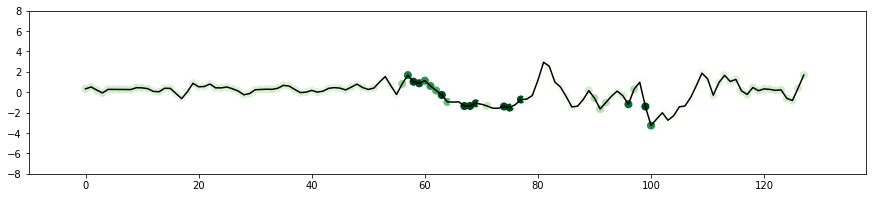

In [74]:
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(1,1,1)
ax.plot(trainX[data_idx,0,:,0].T,color='black')
ax.scatter(range(0,trainX.shape[2]),trainX[data_idx,0,:,0],c = pool3_im.squeeze().T[input_channel],s=50,cmap=cm.Greens,vmin=-0.008,vmax=0.03 )

ax.set_ylim(-8,8)
ax.set_xlim([0-10,int(trainX.shape[2])+10])

In [160]:
unit=58
input_channel = 6

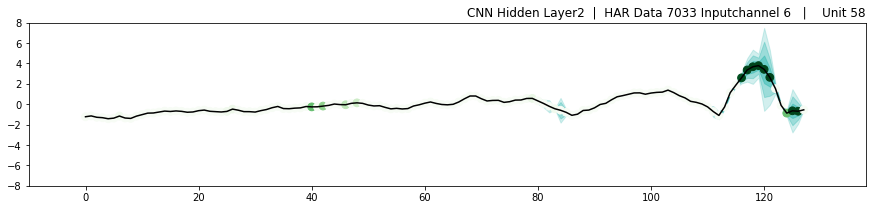

In [164]:
data_idx= 7033
dropout_imlist=[]

mc_num=300
for mc_idx in range(mc_num):
    temp =np.zeros(1*len(conv2_idx_list) *conv2_channel).reshape(1,1,len(conv2_idx_list),conv2_channel)
    temp[:,:,:,unit]=1.0
    pool3_im = F_list[-1].eval(session=sess, feed_dict = {x: trainX[data_idx].reshape(-1,1,trainX.shape[2],trainX.shape[3]), 
                                                           y_:trainY[data_idx].reshape(-1,nb_classes),
                                                          unit_bool: temp, keep_prob:0.5})
    dropout_imlist.append(pool3_im.squeeze())

uncertainty = np.asarray(dropout_imlist).std(axis=0)
mean = np.asarray(dropout_imlist).mean(axis=0)

fig = plt.figure(figsize=(15,3))
ax = plt.subplot(1,1,1)
error = uncertainty.T[input_channel]
ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-5*error), (trainX[data_idx,0,:,input_channel].squeeze()+5*error), color='lightseagreen', alpha=0.4)
ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-10*error), (trainX[data_idx,0,:,input_channel].squeeze()+10*error),  color='lightseagreen', alpha=0.3)
ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-15*error), (trainX[data_idx,0,:,input_channel].squeeze()+15*error),  color='lightseagreen', alpha=0.2)

ax.plot(trainX[data_idx,0,:,input_channel].T,color='black')
ax.scatter(range(0,trainX.shape[2]),trainX[data_idx,0,:,input_channel],c = mean.T[input_channel],s=60, cmap=cm.Greens,vmin=0,vmax=max(  mean.T[input_channel].mean() + mean.T[input_channel].std(), 0.001))



ax.set_ylim(-8,8)
ax.set_xlim([0-10,int(trainX.shape[2])+10])
ax.set_title( "CNN Hidden Layer2  |  {} Data {} Inputchannel {}   |    Unit {}".format(data_name, data_idx,input_channel, unit), loc='right')